# Reinforcement Learning: Q-Learning Algorithm

## 1. Introduction to Reinforcement Learning

Reinforcement Learning (RL) is a paradigm of machine learning where an **agent** learns to make decisions by interacting with an **environment**. Unlike supervised learning, the agent is not given explicit correct answers but instead receives **rewards** or **penalties** based on its actions.

### 1.1 The Markov Decision Process (MDP)

RL problems are typically formalized as a **Markov Decision Process** (MDP), defined by the tuple $(\mathcal{S}, \mathcal{A}, P, R, \gamma)$:

- $\mathcal{S}$: State space (set of all possible states)
- $\mathcal{A}$: Action space (set of all possible actions)
- $P(s'|s,a)$: State transition probability
- $R(s,a,s')$: Reward function
- $\gamma \in [0,1]$: Discount factor

### 1.2 The Value Function

The **state-value function** $V^\pi(s)$ represents the expected cumulative reward starting from state $s$ and following policy $\pi$:

$$V^\pi(s) = \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t R_{t+1} \,\bigg|\, S_0 = s\right]$$

### 1.3 The Action-Value Function (Q-Function)

The **action-value function** $Q^\pi(s,a)$ represents the expected cumulative reward starting from state $s$, taking action $a$, and then following policy $\pi$:

$$Q^\pi(s,a) = \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t R_{t+1} \,\bigg|\, S_0 = s, A_0 = a\right]$$

## 2. Q-Learning Algorithm

### 2.1 The Bellman Optimality Equation

The optimal Q-function satisfies the **Bellman optimality equation**:

$$Q^*(s,a) = \mathbb{E}\left[R_{t+1} + \gamma \max_{a'} Q^*(S_{t+1}, a') \,\bigg|\, S_t = s, A_t = a\right]$$

### 2.2 Temporal Difference Learning

Q-Learning is an **off-policy temporal difference (TD)** algorithm that directly approximates $Q^*$ without requiring a model of the environment. The update rule is:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t)\right]$$

where:
- $\alpha \in (0,1]$ is the **learning rate**
- $r_{t+1}$ is the immediate reward
- $\gamma$ is the discount factor
- $\max_{a} Q(s_{t+1}, a)$ is the maximum Q-value at the next state

The term in brackets is called the **TD error**:

$$\delta_t = r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t)$$

### 2.3 Exploration vs. Exploitation: $\epsilon$-Greedy Policy

To balance exploration and exploitation, Q-Learning uses an **$\epsilon$-greedy policy**:

$$a = \begin{cases} \text{random action} & \text{with probability } \epsilon \\ \arg\max_a Q(s, a) & \text{with probability } 1-\epsilon \end{cases}$$

## 3. Implementation: GridWorld Environment

We will implement Q-Learning on a simple **GridWorld** environment where an agent must navigate from a starting position to a goal while avoiding obstacles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
class GridWorld:
    """
    A simple GridWorld environment for reinforcement learning.
    
    The agent starts at position (0, 0) and must reach the goal at (grid_size-1, grid_size-1).
    Obstacles provide negative rewards, and reaching the goal provides a positive reward.
    """
    
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.start = (0, 0)
        self.goal = (grid_size - 1, grid_size - 1)
        
        # Actions: 0=up, 1=right, 2=down, 3=left
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.n_actions = len(self.actions)
        self.n_states = grid_size * grid_size
        
        # Define obstacles (negative reward areas)
        self.obstacles = [(1, 1), (1, 3), (2, 1), (3, 3), (2, 3)]
        
        self.state = self.start
    
    def reset(self):
        """Reset the environment to the starting state."""
        self.state = self.start
        return self._state_to_index(self.state)
    
    def _state_to_index(self, state):
        """Convert (row, col) to a single state index."""
        return state[0] * self.grid_size + state[1]
    
    def _index_to_state(self, index):
        """Convert state index to (row, col)."""
        return (index // self.grid_size, index % self.grid_size)
    
    def step(self, action):
        """
        Take an action and return (next_state, reward, done).
        """
        # Calculate next position
        dr, dc = self.actions[action]
        new_row = max(0, min(self.grid_size - 1, self.state[0] + dr))
        new_col = max(0, min(self.grid_size - 1, self.state[1] + dc))
        self.state = (new_row, new_col)
        
        # Determine reward
        if self.state == self.goal:
            reward = 10.0  # Goal reward
            done = True
        elif self.state in self.obstacles:
            reward = -5.0  # Obstacle penalty
            done = False
        else:
            reward = -0.1  # Small step penalty to encourage efficiency
            done = False
        
        return self._state_to_index(self.state), reward, done
    
    def render(self, q_table=None):
        """Visualize the grid and optionally the policy."""
        grid = np.zeros((self.grid_size, self.grid_size))
        
        # Mark obstacles
        for obs in self.obstacles:
            grid[obs] = 1
        
        # Mark goal
        grid[self.goal] = 2
        
        return grid

In [3]:
class QLearningAgent:
    """
    Q-Learning agent that learns an optimal policy through interaction with the environment.
    
    Parameters:
    -----------
    n_states : int
        Number of states in the environment
    n_actions : int
        Number of possible actions
    alpha : float
        Learning rate (0 < alpha <= 1)
    gamma : float
        Discount factor (0 <= gamma <= 1)
    epsilon : float
        Exploration rate for epsilon-greedy policy
    epsilon_decay : float
        Rate at which epsilon decays over episodes
    epsilon_min : float
        Minimum value of epsilon
    """
    
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((n_states, n_actions))
    
    def choose_action(self, state):
        """
        Choose an action using epsilon-greedy policy.
        
        With probability epsilon: choose random action (exploration)
        With probability 1-epsilon: choose best action (exploitation)
        """
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """
        Update Q-value using the Q-learning update rule:
        Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
        """
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * np.max(self.q_table[next_state])
        
        # TD error
        td_error = td_target - self.q_table[state, action]
        
        # Update Q-value
        self.q_table[state, action] += self.alpha * td_error
        
        return td_error
    
    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

## 4. Training the Q-Learning Agent

We will now train the agent over multiple episodes. During training, we track:
- **Episode rewards**: Total reward accumulated per episode
- **Episode lengths**: Number of steps taken to reach the goal
- **Epsilon values**: The exploration rate over time

In [4]:
def train_agent(env, agent, n_episodes=500, max_steps=100):
    """
    Train the Q-learning agent.
    
    Parameters:
    -----------
    env : GridWorld
        The environment
    agent : QLearningAgent
        The learning agent
    n_episodes : int
        Number of training episodes
    max_steps : int
        Maximum steps per episode
    
    Returns:
    --------
    dict : Training history containing rewards, lengths, and epsilon values
    """
    history = {
        'rewards': [],
        'lengths': [],
        'epsilons': []
    }
    
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.choose_action(state)
            
            # Take action
            next_state, reward, done = env.step(action)
            
            # Update Q-table
            agent.update(state, action, reward, next_state, done)
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        # Record history
        history['rewards'].append(total_reward)
        history['lengths'].append(step + 1)
        history['epsilons'].append(agent.epsilon)
        
        # Decay exploration rate
        agent.decay_epsilon()
        
        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(history['rewards'][-100:])
            avg_length = np.mean(history['lengths'][-100:])
            print(f"Episode {episode + 1}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Length: {avg_length:.1f} | "
                  f"Epsilon: {agent.epsilon:.4f}")
    
    return history

In [5]:
# Create environment and agent
env = GridWorld(grid_size=5)
agent = QLearningAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    alpha=0.1,      # Learning rate
    gamma=0.99,     # Discount factor
    epsilon=1.0,    # Initial exploration rate
    epsilon_decay=0.995,
    epsilon_min=0.01
)

# Train the agent
print("Training Q-Learning Agent...\n")
history = train_agent(env, agent, n_episodes=500, max_steps=100)
print("\nTraining complete!")

Training Q-Learning Agent...

Episode 100/500 | Avg Reward: -25.40 | Avg Length: 39.2 | Epsilon: 0.6058
Episode 200/500 | Avg Reward: 2.44 | Avg Length: 14.8 | Epsilon: 0.3670
Episode 300/500 | Avg Reward: 6.36 | Avg Length: 11.4 | Epsilon: 0.2223
Episode 400/500 | Avg Reward: 7.48 | Avg Length: 9.5 | Epsilon: 0.1347
Episode 500/500 | Avg Reward: 8.03 | Avg Length: 9.0 | Epsilon: 0.0816

Training complete!


## 5. Results Analysis and Visualization

We now analyze the training results by visualizing:
1. **Learning curves**: Episode rewards and lengths over time
2. **Learned Q-values**: The final Q-table as a heatmap
3. **Optimal policy**: The best action at each state
4. **Agent trajectory**: Path taken by the trained agent

Figure saved to 'plot.png'


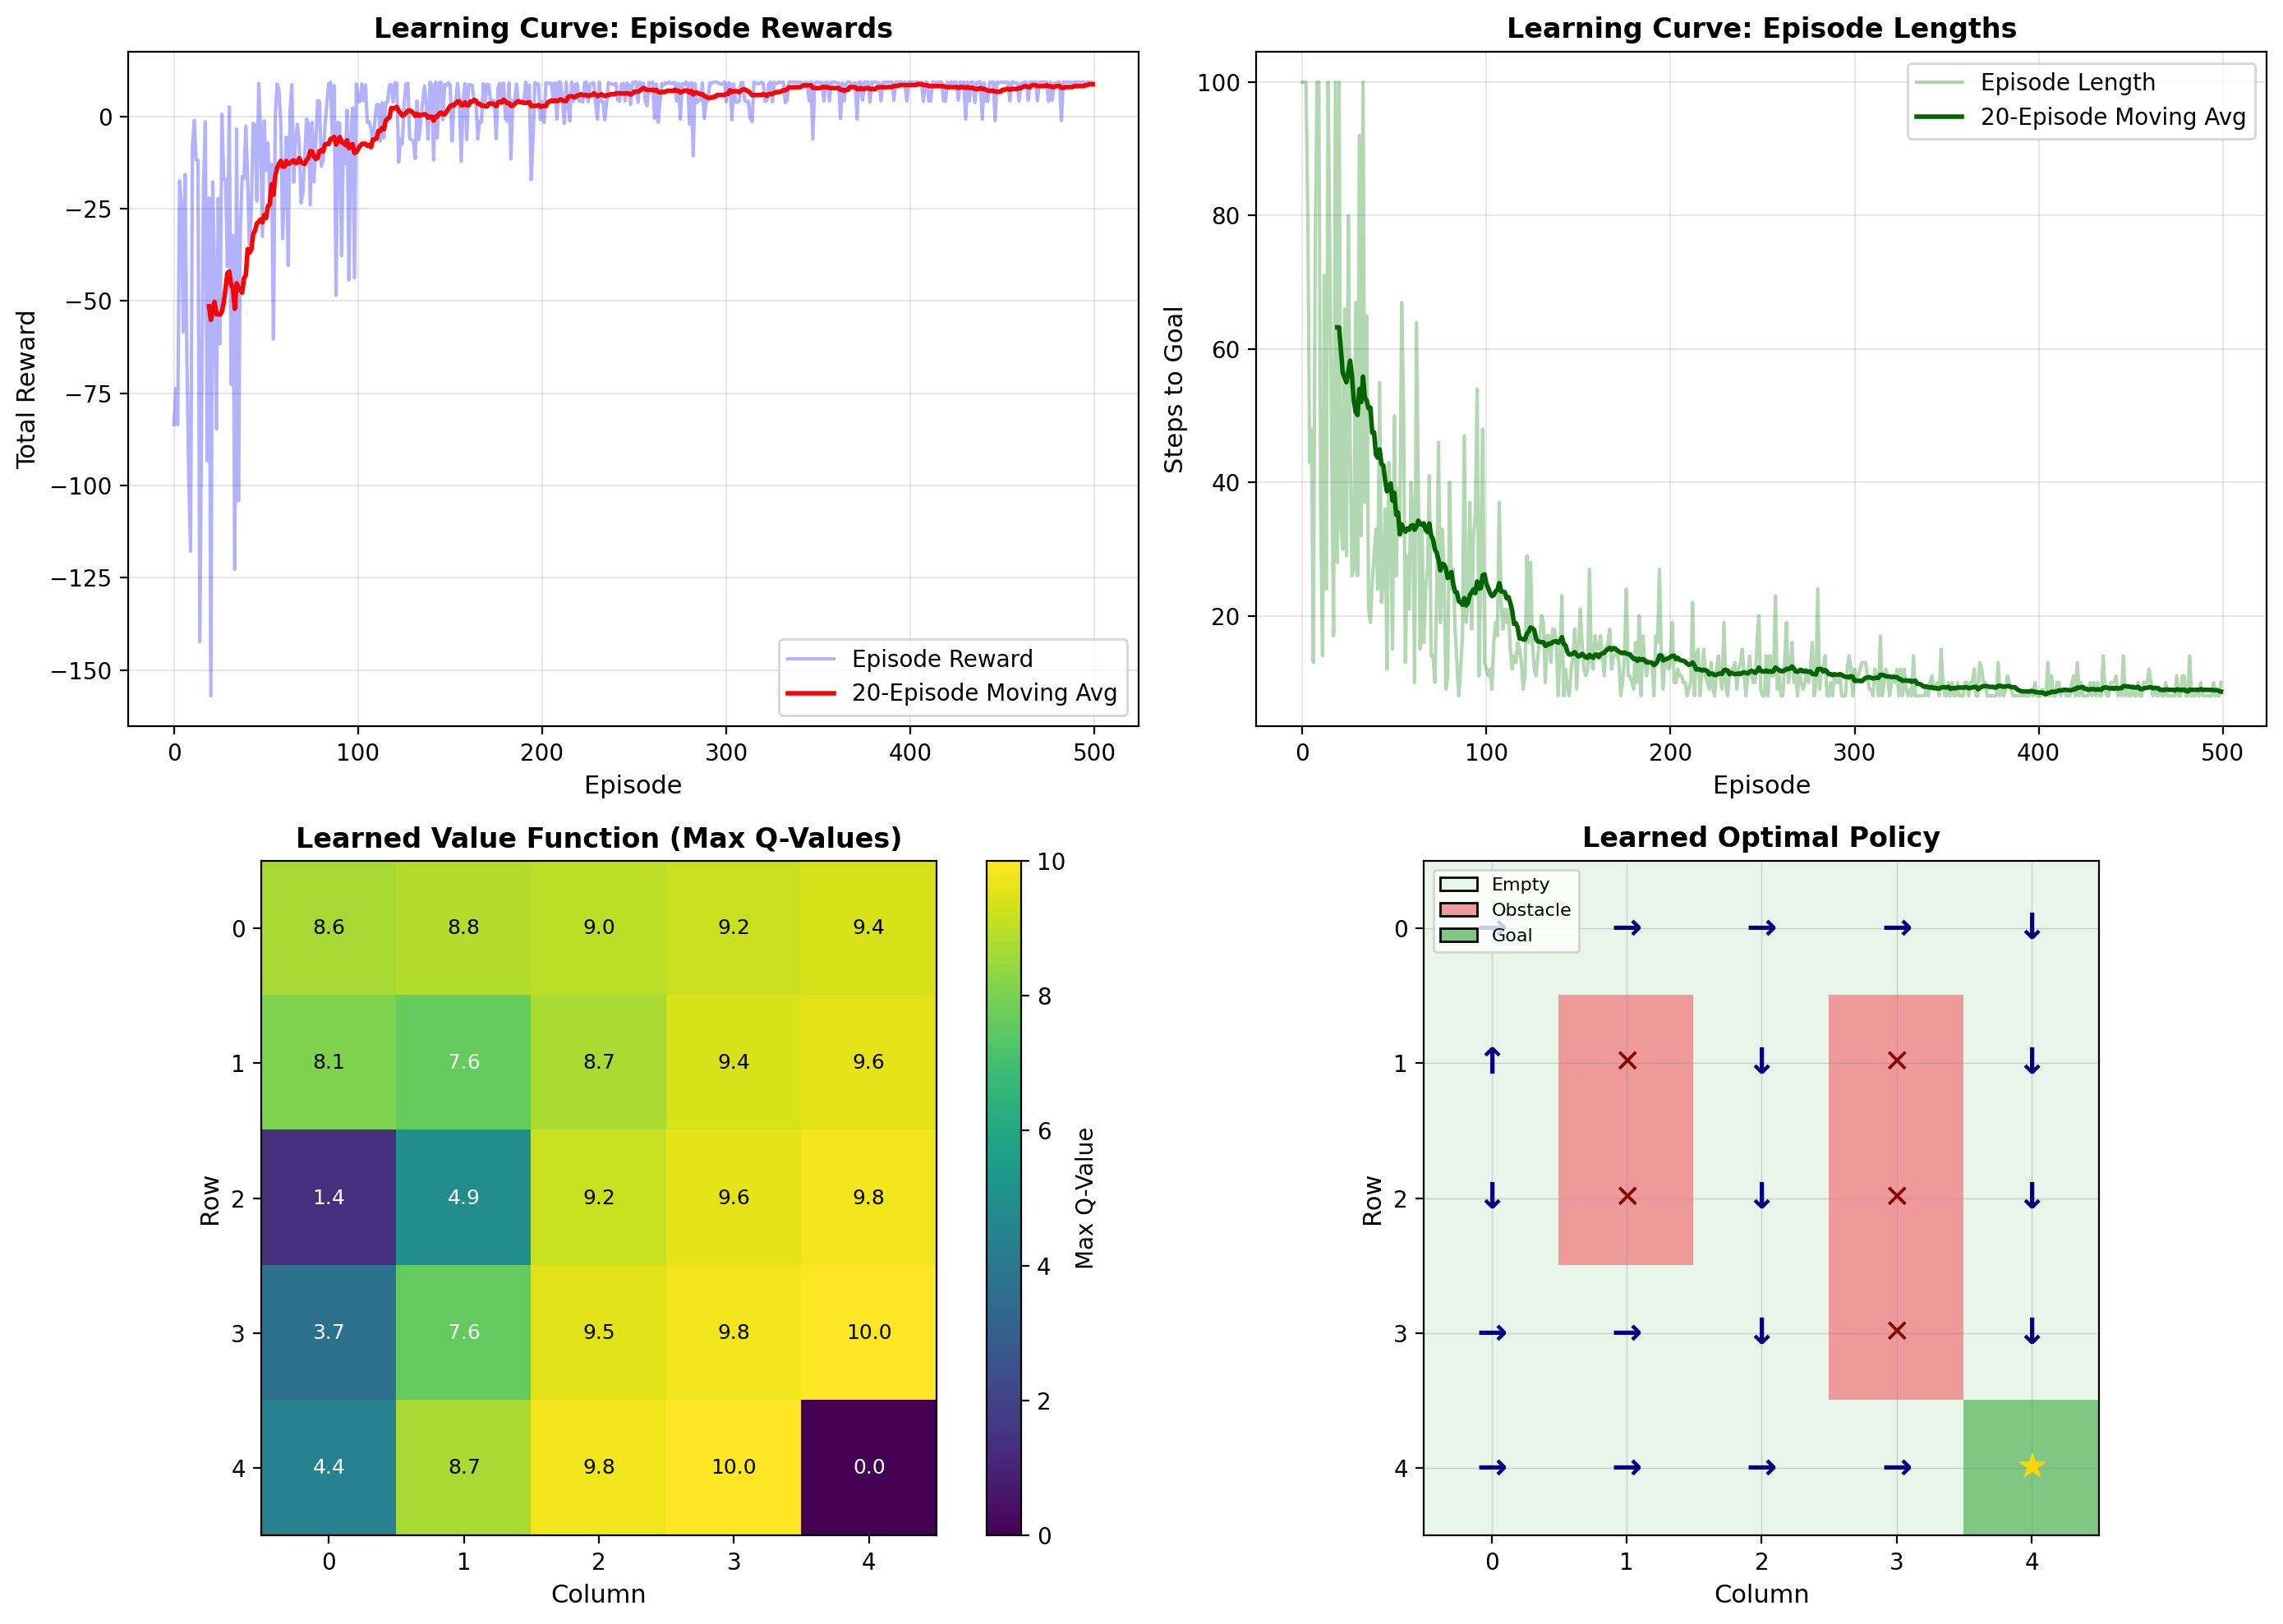

In [6]:
def plot_training_results(history, agent, env):
    """
    Create comprehensive visualization of Q-learning results.
    """
    fig = plt.figure(figsize=(14, 10))
    
    # 1. Episode Rewards (with moving average)
    ax1 = fig.add_subplot(2, 2, 1)
    rewards = history['rewards']
    window = 20
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
    ax1.plot(range(window-1, len(rewards)), moving_avg, color='red', 
             linewidth=2, label=f'{window}-Episode Moving Avg')
    ax1.set_xlabel('Episode', fontsize=11)
    ax1.set_ylabel('Total Reward', fontsize=11)
    ax1.set_title('Learning Curve: Episode Rewards', fontsize=12, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Episode Lengths
    ax2 = fig.add_subplot(2, 2, 2)
    lengths = history['lengths']
    moving_avg_len = np.convolve(lengths, np.ones(window)/window, mode='valid')
    ax2.plot(lengths, alpha=0.3, color='green', label='Episode Length')
    ax2.plot(range(window-1, len(lengths)), moving_avg_len, color='darkgreen', 
             linewidth=2, label=f'{window}-Episode Moving Avg')
    ax2.set_xlabel('Episode', fontsize=11)
    ax2.set_ylabel('Steps to Goal', fontsize=11)
    ax2.set_title('Learning Curve: Episode Lengths', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Values Heatmap (max Q-value at each state)
    ax3 = fig.add_subplot(2, 2, 3)
    q_max = np.max(agent.q_table, axis=1).reshape(env.grid_size, env.grid_size)
    im = ax3.imshow(q_max, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax3, label='Max Q-Value')
    
    # Add text annotations
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            text_color = 'white' if q_max[i, j] < np.mean(q_max) else 'black'
            ax3.text(j, i, f'{q_max[i, j]:.1f}', ha='center', va='center', 
                    color=text_color, fontsize=9)
    
    ax3.set_xlabel('Column', fontsize=11)
    ax3.set_ylabel('Row', fontsize=11)
    ax3.set_title('Learned Value Function (Max Q-Values)', fontsize=12, fontweight='bold')
    ax3.set_xticks(range(env.grid_size))
    ax3.set_yticks(range(env.grid_size))
    
    # 4. Optimal Policy Visualization
    ax4 = fig.add_subplot(2, 2, 4)
    
    # Create grid
    grid = np.zeros((env.grid_size, env.grid_size))
    for obs in env.obstacles:
        grid[obs] = 1
    grid[env.goal] = 2
    
    # Custom colormap
    colors = ['#E8F5E9', '#EF9A9A', '#81C784']  # Empty, Obstacle, Goal
    cmap = ListedColormap(colors)
    ax4.imshow(grid, cmap=cmap, interpolation='nearest')
    
    # Draw policy arrows
    arrow_symbols = ['↑', '→', '↓', '←']
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i, j) == env.goal:
                ax4.text(j, i, '★', ha='center', va='center', fontsize=16, color='gold')
            elif (i, j) in env.obstacles:
                ax4.text(j, i, '✕', ha='center', va='center', fontsize=14, color='darkred')
            else:
                state_idx = i * env.grid_size + j
                best_action = np.argmax(agent.q_table[state_idx])
                ax4.text(j, i, arrow_symbols[best_action], ha='center', va='center', 
                        fontsize=16, color='navy', fontweight='bold')
    
    ax4.set_xlabel('Column', fontsize=11)
    ax4.set_ylabel('Row', fontsize=11)
    ax4.set_title('Learned Optimal Policy', fontsize=12, fontweight='bold')
    ax4.set_xticks(range(env.grid_size))
    ax4.set_yticks(range(env.grid_size))
    ax4.grid(True, alpha=0.3, color='gray', linewidth=0.5)
    
    # Add legend
    legend_elements = [
        mpatches.Patch(facecolor='#E8F5E9', edgecolor='black', label='Empty'),
        mpatches.Patch(facecolor='#EF9A9A', edgecolor='black', label='Obstacle'),
        mpatches.Patch(facecolor='#81C784', edgecolor='black', label='Goal')
    ]
    ax4.legend(handles=legend_elements, loc='upper left', fontsize=8)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('reinforcement_learning_q_learning_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
    print("Figure saved to 'plot.png'")
    
    plt.show()
    
    return fig

# Generate visualization
fig = plot_training_results(history, agent, env)

## 6. Evaluating the Trained Agent

Let's test the trained agent by running it through the environment using the learned policy (without exploration).

In [7]:
def evaluate_agent(env, agent, n_episodes=10):
    """
    Evaluate the trained agent without exploration.
    """
    original_epsilon = agent.epsilon
    agent.epsilon = 0  # Pure exploitation
    
    total_rewards = []
    total_steps = []
    
    print("Evaluation Results:")
    print("-" * 40)
    
    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        path = [env._index_to_state(state)]
        
        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            episode_reward += reward
            path.append(env._index_to_state(next_state))
            state = next_state
            
            if done:
                break
        
        total_rewards.append(episode_reward)
        total_steps.append(step + 1)
        
        status = "SUCCESS" if done else "FAILED"
        print(f"Episode {episode + 1}: {status} | Reward: {episode_reward:.2f} | Steps: {step + 1}")
    
    print("-" * 40)
    print(f"Average Reward: {np.mean(total_rewards):.2f} ± {np.std(total_rewards):.2f}")
    print(f"Average Steps: {np.mean(total_steps):.1f} ± {np.std(total_steps):.1f}")
    print(f"Success Rate: {sum([1 for r in total_rewards if r > 0]) / n_episodes * 100:.1f}%")
    
    agent.epsilon = original_epsilon
    return total_rewards, total_steps

# Evaluate the trained agent
eval_rewards, eval_steps = evaluate_agent(env, agent, n_episodes=10)

Evaluation Results:
----------------------------------------
Episode 1: SUCCESS | Reward: 9.30 | Steps: 8
Episode 2: SUCCESS | Reward: 9.30 | Steps: 8
Episode 3: SUCCESS | Reward: 9.30 | Steps: 8
Episode 4: SUCCESS | Reward: 9.30 | Steps: 8
Episode 5: SUCCESS | Reward: 9.30 | Steps: 8
Episode 6: SUCCESS | Reward: 9.30 | Steps: 8
Episode 7: SUCCESS | Reward: 9.30 | Steps: 8
Episode 8: SUCCESS | Reward: 9.30 | Steps: 8
Episode 9: SUCCESS | Reward: 9.30 | Steps: 8
Episode 10: SUCCESS | Reward: 9.30 | Steps: 8
----------------------------------------
Average Reward: 9.30 ± 0.00
Average Steps: 8.0 ± 0.0
Success Rate: 100.0%


## 7. Displaying the Final Q-Table

The Q-table contains the learned action-values for each state-action pair. Each row represents a state, and each column represents an action (Up, Right, Down, Left).

In [8]:
import pandas as pd

# Create a formatted Q-table
q_table_df = pd.DataFrame(
    agent.q_table,
    columns=['Up (↑)', 'Right (→)', 'Down (↓)', 'Left (←)'],
    index=[f'State {i} ({i//5}, {i%5})' for i in range(env.n_states)]
)

print("Final Q-Table (rounded to 2 decimal places):")
print("=" * 60)
print(q_table_df.round(2).to_string())

Final Q-Table (rounded to 2 decimal places):
                 Up (↑)  Right (→)  Down (↓)  Left (←)
State 0 (0, 0)     8.28       8.64      6.92      8.31
State 1 (0, 1)     8.37       8.83      1.14      8.00
State 2 (0, 2)     8.44       9.02      7.14      8.00
State 3 (0, 3)     8.94       9.21      4.16      8.36
State 4 (0, 4)     9.09       8.97      9.41      8.78
State 5 (1, 0)     8.07      -2.59      0.46      2.48
State 6 (1, 1)     3.57       7.62     -3.24      0.65
State 7 (1, 2)     5.31      -1.27      8.72     -2.38
State 8 (1, 3)     6.06       9.40      0.57      3.40
State 9 (1, 4)     9.03       9.23      9.60      4.17
State 10 (2, 0)    0.44      -3.94      1.38     -0.08
State 11 (2, 1)   -4.59       3.26      4.91      0.02
State 12 (2, 2)    3.64       2.43      9.18     -2.93
State 13 (2, 3)    0.14       9.58      2.11      3.88
State 14 (2, 4)    9.17       9.54      9.80      4.27
State 15 (3, 0)   -0.03       3.70      0.71      0.75
State 16 (3, 1)   -3

## 8. Conclusion

### Summary

In this notebook, we implemented the **Q-Learning algorithm**, a foundational model-free reinforcement learning technique. Key takeaways:

1. **Q-Learning learns the optimal action-value function** $Q^*(s,a)$ through temporal difference updates, without requiring knowledge of the environment dynamics.

2. **The update rule** $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma\max_{a'}Q(s',a') - Q(s,a)]$ iteratively improves estimates using bootstrapped targets.

3. **Exploration-exploitation tradeoff** is managed through $\epsilon$-greedy policy with decaying $\epsilon$, allowing initial exploration while converging to exploitation.

4. **Convergence**: Given sufficient exploration and appropriate hyperparameters ($\alpha$, $\gamma$), Q-learning is guaranteed to converge to the optimal Q-function.

### Extensions

- **Deep Q-Networks (DQN)**: Replace tabular Q-function with neural network for large/continuous state spaces
- **Double Q-Learning**: Address overestimation bias
- **Prioritized Experience Replay**: Sample important transitions more frequently
- **Dueling DQN**: Separate value and advantage estimation